<a href="https://colab.research.google.com/github/ipediz/BachehayekhafaneTMU/blob/main/Double_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install econml
!pip install itertools
!pip install sklearn
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd

In [ ]:
Data = pd.read_csv(r'All_STATE_CASUAL_READY_2.csv')

In [ ]:
Data['Treatment'] = Data['Treatment'].replace({1: True, 0: False})

In [ ]:
from tabulate import tabulate

columns_to_drop = [
    'relative_time_m8andbeyond', 'relative_time_m7', 'relative_time_m6', 'relative_time_m5',
    'relative_time_m4', 'relative_time_m3', 'relative_time_m2', 'relative_time_m1', 'relative_time_0',
    'relative_time_p1', 'relative_time_p2', 'relative_time_p3', 'relative_time_p4',
    'relative_time_p5', 'relative_time_p6', 'relative_time_p7', 'relative_time_p8andbeyond',
    'cem_strata', 'cem_weights', 'new_timeperiod','county_code', 'nonbusiness_bankruptcy_percapita','business_bankruptcy_percapita', 'log_bankruptcy'
]


Data1= Data.drop(columns=columns_to_drop)
Data1 = Data1.dropna();

In [ ]:
from econml.dr import LinearDRLearner
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier



# Adjusted variables: X, T, and y from Data
Y = Data1['bankruptcy_per_capita'].values
T = Data1['Treatment'].values
X = Data1[['population_estimation']].values.reshape(-1, 1)

# Ensure W is already 2D (which it is in your case)
W = Data1[['monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals']].values
# Fit the model



In [ ]:
print("X shape:", X.shape)  # Should be (n_samples, n_features)
print("W shape:", W.shape)  # Should be (n_samples, n_features)

X shape: (64428, 1)
W shape: (64428, 4)


In [ ]:
import numpy as np

# Define the number of test samples
n_test = 13000  # Number of test samples

# Construct X_test for effect modifiers
# Replace X with only the variables you want to explore for treatment effect heterogeneity
X_test = np.zeros((n_test, 1))  # Initialize with the number of effect modifier features (e.g., 1 feature)
X_test[:, 0] = np.linspace(Data1['population_estimation'].min(), Data1['population_estimation'].max(), n_test)  # Sweeping 'population_estimation'

# Construct W_test for control variables
W_test = np.zeros((n_test, 4))  # Remaining 4 features as controls
W_test[:, 0] = np.random.uniform(Data1['monthly_earnings'].min(), Data1['monthly_earnings'].max(), n_test)
W_test[:, 1] = np.random.uniform(Data1['medianhouseholdincome'].min(), Data1['medianhouseholdincome'].max(), n_test)
W_test[:, 2] = np.random.uniform(Data1['labor_force'].min(), Data1['labor_force'].max(), n_test)
W_test[:, 3] = np.random.uniform(Data1['employed_individuals'].min(), Data1['employed_individuals'].max(), n_test)

# Verify the test datasets
print("Shape of X_test:", X_test.shape)
print("Shape of W_test:", W_test.shape)
print("Sample of X_test:\n", X_test[:5])  # Print a sample of effect modifiers
print("Sample of W_test:\n", W_test[:5])  # Print a sample of control variables


Shape of X_test: (13000, 1)
Shape of W_test: (13000, 4)
Sample of X_test:
 [[0.25799999]
 [0.29982836]
 [0.34165673]
 [0.3834851 ]
 [0.42531347]]
Sample of W_test:
 [[ 15.78507103  37.40153957 151.2413681  287.95008786]
 [ 22.85669639  46.96751075 122.2969523  182.90610241]
 [ 23.30271974  36.41769696 147.20780507 248.02236105]
 [ 14.85363026  75.89527697  88.9123849  174.28975309]
 [ 22.57842654  50.10990903  39.0151505   26.06895582]]


In [ ]:
est = LinearDML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestClassifier(min_samples_leaf=10),
    discrete_treatment=True,
    cv=6
)

# Fit the model
est.fit(Y, T, X=X, W=W)



In [ ]:
te_pred = est.effect(X_test)  # Only pass X_test
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [ ]:
# Define the SparseLinearDML model
est2 = SparseLinearDML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestClassifier(min_samples_leaf=10),
    discrete_treatment=True,
    featurizer=PolynomialFeatures(degree=1),  # Using polynomial features of degree 1
    cv=6
)

# Fit the model
est2.fit(Y, T, X=X, W=W)

In [ ]:
te_pred2 = est2.effect(X_test)  # Only pass X_test
lb2, ub2 = est2.effect_interval(X_test, alpha=0.01)

In [ ]:


# Save results for LinearDML
np.savez('linear_dml_results.npz', te_pred=te_pred, lb=lb, ub=ub)

# Save results for SparseLinearDML
np.savez('sparse_linear_dml_results.npz', te_pred2=te_pred2, lb2=lb2, ub2=ub2)


In [ ]:
# Load results for LinearDML
linear_results = np.load('linear_dml_results.npz')
te_pred = linear_results['te_pred']
lb = linear_results['lb']
ub = linear_results['ub']

# Load results for SparseLinearDML
sparse_results = np.load('sparse_linear_dml_results.npz')
te_pred2 = sparse_results['te_pred2']
lb2 = sparse_results['lb2']
ub2 = sparse_results['ub2']


In [ ]:
# Define the CausalForestDML model
est3 = CausalForestDML(
    model_y=RandomForestRegressor(),
    model_t=RandomForestClassifier(min_samples_leaf=10),
    discrete_treatment=True,
    n_estimators=800,
    min_impurity_decrease=0.001,
    verbose=0,
    cv=6
)

# Tune the model (includes W during tuning)
est3.tune(Y, T, X=X, W=W)

# Fit the model
est3.fit(Y, T, X=X, W=W)

In [ ]:
te_pred3 = est3.effect(X_test)  # Only pass X_test
lb3, ub3 = est3.effect_interval(X_test, alpha=0.01)

In [ ]:
est3.feature_importances_

array([0.])

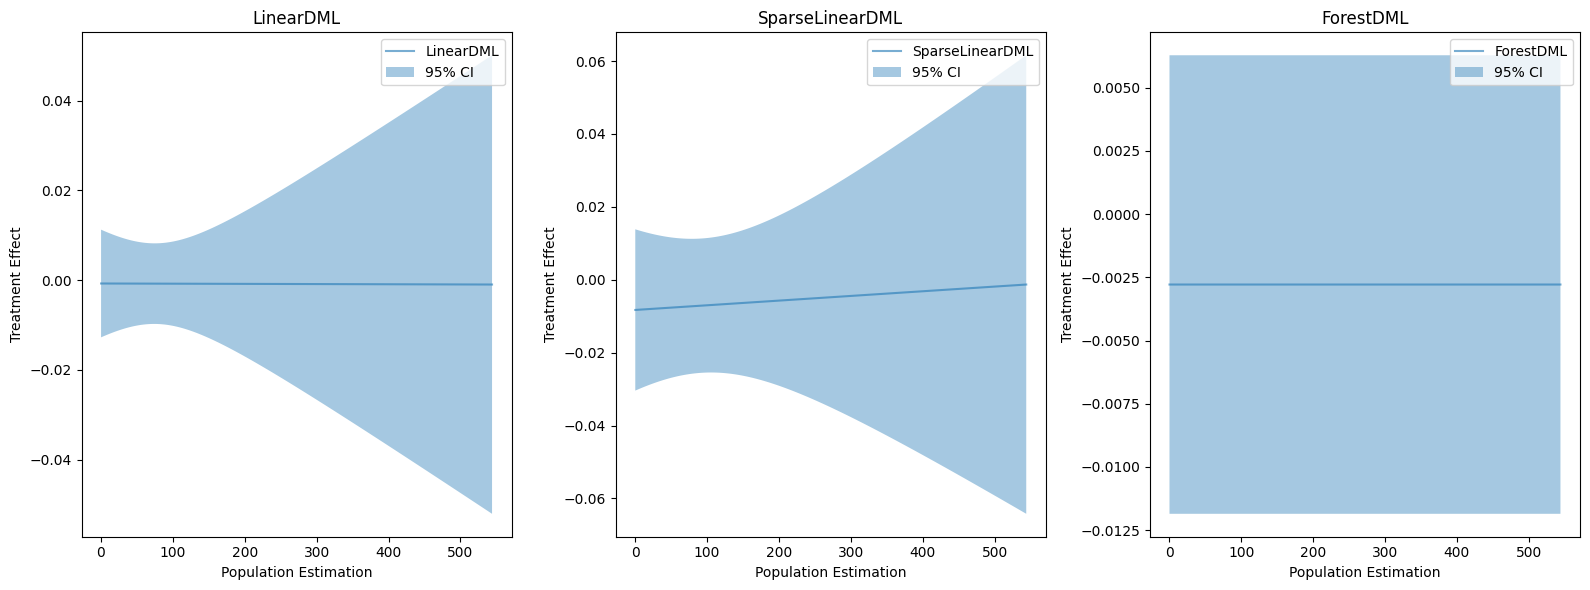

In [ ]:
plt.figure(figsize=(16, 6))

# Subplot 1: LinearDML
plt.subplot(1, 3, 1)
plt.plot(X_test[:, 0], te_pred, label='LinearDML', alpha=0.6)  # Predicted treatment effect
plt.fill_between(X_test[:, 0], lb, ub, alpha=0.4, label='95% CI')  # Confidence interval
plt.ylabel('Treatment Effect')
plt.xlabel('Population Estimation')  # Feature: Population Estimation
plt.legend()
plt.title('LinearDML')

# Subplot 2: SparseLinearDML
plt.subplot(1, 3, 2)
plt.plot(X_test[:, 0], te_pred2, label='SparseLinearDML', alpha=0.6)
plt.fill_between(X_test[:, 0], lb2, ub2, alpha=0.4, label='95% CI')
plt.ylabel('Treatment Effect')
plt.xlabel('Population Estimation')
plt.legend()
plt.title('SparseLinearDML')

# Subplot 3: ForestDML
plt.subplot(1, 3, 3)
plt.plot(X_test[:, 0], te_pred3, label='ForestDML', alpha=0.6)
plt.fill_between(X_test[:, 0], lb3, ub3, alpha=0.4, label='95% CI')
plt.ylabel('Treatment Effect')
plt.xlabel('Population Estimation')
plt.legend()
plt.title('ForestDML')

plt.tight_layout()
plt.show()

In [ ]:
Data1['Treatment'] = Data1['Treatment'].replace({True: 1, False: 0})


In [ ]:
import shap

In [ ]:
T = Data1['Treatment'].values  # Ensure Treatment is binary (0/1 or True/False)
est.fit(Y, T, X=X, W=W)


In [ ]:
te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.1)


In [ ]:
est.effect_inference(X_test[:10,]).summary_frame(alpha=0.1, value=0, decimals=13)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,-0.000898,0.004700,-0.190972,0.848547,-0.008628,0.006833
1,-0.000898,0.004699,-0.191171,0.848391,-0.008627,0.006830
2,-0.000899,0.004697,-0.191371,0.848235,-0.008625,0.006828
3,-0.000900,0.004696,-0.191570,0.848079,-0.008624,0.006825
4,-0.000900,0.004695,-0.191769,0.847923,-0.008623,0.006822
5,-0.000901,0.004694,-0.191969,0.847767,-0.008622,0.006820
6,-0.000902,0.004693,-0.192169,0.847610,-0.008621,0.006817
7,-0.000903,0.004692,-0.192368,0.847454,-0.008619,0.006814
8,-0.000903,0.004690,-0.192568,0.847297,-0.008618,0.006812


In [ ]:
est.effect_inference(X_test).population_summary(alpha=0.1, value=0, decimals=10, tol=0.001)

In [ ]:
# Evaluate coefficients for treatment = 1
coef_summary = est.coef__inference(T=1).summary_frame()
print(coef_summary)


    point_estimate  stderr  zstat  pvalue  ci_lower  ci_upper
X                                                            
X0             0.0     0.0   0.03   0.976      -0.0       0.0


In [ ]:
est3.ate_

NameError: name 'est2' is not defined

In [ ]:
est3.ate__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
ATE,-0.002,0.002,-0.844,0.399,-0.005,0.002


In [ ]:
est3.ate__inference().summary_frame()